# Comparison of `Moran_Local` results with `pygeoda`

In [1]:
from importlib import reload
import sys
sys.path.insert(0, "../")
import esda
import libpysal as ps
import geopandas
import pandas
import numpy as np
import os

PERMS = 9999

from libpysal.examples import get_path, load_example, fetch_all

In [2]:
esda

<module 'esda' from '../esda/__init__.py'>

In [3]:
#fetch_all()
_ = load_example("NCOVR")

nat = geopandas.read_file(get_path("NAT.shp"))

- Load up data

In [4]:
y_name = "HR70"
#y_name = "HOVAL"
db = geopandas.read_file(get_path("NAT.shp"))

w = ps.weights.Queen.from_dataframe(db)
cardinalities = pandas.Series(w.cardinalities).values

## LISA conditional randomisation

- `Moran_Local` in `esda`. Single thread.

In [5]:
reload(esda.moran)
lisa = esda.Moran_Local(db[y_name], w, permutations=PERMS)
%timeit lisa = esda.Moran_Local(db[y_name], w, permutations=PERMS)

4.01 s ± 490 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- `Moran_Local` in `esda`. Parallel.

In [6]:
print(f"Running parallel implementation on {os.cpu_count()} cores")
lisa = esda.Moran_Local(db[y_name], w, permutations=PERMS, 
                        n_jobs=-1)
%timeit lisa = esda.Moran_Local(db[y_name], w, permutations=PERMS, \
                                n_jobs=-1)

Running parallel implementation on 2 cores
5.81 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


---

In [7]:
import pygeoda

db_geoda = pygeoda.open(get_path("NAT.shp"))
y = db_geoda.GetIntegerCol(y_name)
w_geoda = pygeoda.weights.queen(db_geoda)

In [8]:
%timeit lisa_geoda = pygeoda.local_moran(w_geoda, y)
lisa_geoda = pygeoda.local_moran(w_geoda, y)
lisa_geoda.SetPermutations(PERMS)
%timeit lisa_geoda.Run()

721 ms ± 21.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.2 s ± 52.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- Comparison of P-values

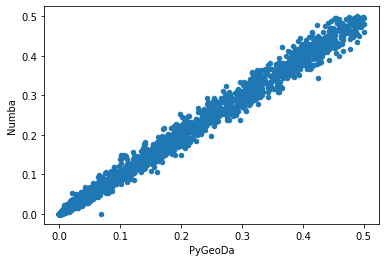

In [12]:
pandas.DataFrame({"PyGeoDa": lisa_geoda.GetPValues(),
                  "Numba": lisa.p_sim
                 }).plot.scatter("PyGeoDa", "Numba")